In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
%matplotlib inline
tf.logging.set_verbosity(tf.logging.INFO)

In [4]:
from sklearn.preprocessing import OneHotEncoder

In [5]:
tf.reset_default_graph()

In [6]:
# Load training and test data
((train_data, train_labels),(test_data, test_labels)) = tf.keras.datasets.mnist.load_data()

train_data = train_data/np.float32(255)
test_data = test_data/np.float32(255)

ohe=OneHotEncoder(sparse=False, categories='auto')
train_labels=ohe.fit_transform(train_labels.reshape(-1,1))
test_labels=ohe.fit_transform(test_labels.reshape(-1,1))

In [7]:
x = tf.placeholder(tf.float32, shape=[None,28,28], name='X')
x_img = tf.reshape(x, [-1,28,28,1])
y_label = tf.placeholder(tf.float32, shape=[None, 10], name='y_label')
y_true = tf.argmax(y_label, axis=1)

rate = tf.placeholder(tf.float32, name='rate')

# Layer Functions

In [8]:
def conv_layer(inp, num_inp_channels, filter_size, num_filters):
    shape = [filter_size, filter_size, num_inp_channels, num_filters]
    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.1))
    biases = tf.Variable(tf.constant(0.1, shape=[num_filters]))
    layer = tf.nn.conv2d(input=inp, filter=weights, strides=[1,1,1,1], padding='SAME')
    return tf.add(layer, biases)

In [9]:
def pool_layer(inp):
    layer = tf.nn.max_pool(value=inp, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    return layer

In [10]:
def fc_layer(inp, num_inps, num_outs):
    weights = tf.Variable(tf.truncated_normal([num_inps, num_outs], stddev=0.1))
    biases = tf.Variable(tf.constant(0.1, shape=[num_outs]))
    return tf.add(tf.matmul(inp,weights), biases)

# Create CNN

In [11]:
conv1 = tf.nn.relu(conv_layer(inp=x_img, num_inp_channels=1, filter_size=5, num_filters=6))
pool1 = pool_layer(conv1)
conv2 = tf.nn.relu(conv_layer(inp=pool1, num_inp_channels=6, filter_size=5, num_filters=16))
pool2 = pool_layer(conv2)

num_features = pool2.shape[1:].num_elements()
flat_layer = tf.reshape(pool2, [-1, num_features])

fc1 = tf.nn.relu(fc_layer(flat_layer, num_inps=num_features, num_outs=128))
fc2 = fc_layer(fc1, num_inps=128, num_outs=10)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
pool1,pool2

(<tf.Tensor 'MaxPool:0' shape=(?, 14, 14, 6) dtype=float32>,
 <tf.Tensor 'MaxPool_1:0' shape=(?, 7, 7, 16) dtype=float32>)

In [13]:
flat_layer

<tf.Tensor 'Reshape_1:0' shape=(?, 784) dtype=float32>

In [14]:
x_img

<tf.Tensor 'Reshape:0' shape=(?, 28, 28, 1) dtype=float32>

In [15]:
conv1

<tf.Tensor 'Relu:0' shape=(?, 28, 28, 6) dtype=float32>

In [16]:
y_pred = tf.nn.softmax(fc2)
y_pred_val = tf.argmax(y_pred, axis=1)

# Cost Function

In [17]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=fc2, labels=y_label)
cost = tf.reduce_mean(cross_entropy)

In [18]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

# Accuracy

In [19]:
correct_preds = tf.equal(y_pred_val, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

In [20]:
num_epochs = 10
batch_size = 100

# TF session

In [21]:
from time import time

In [22]:
saver = tf.train.Saver()

In [23]:
def batch_gen(t_data, t_labels, batch_size):
    cut=np.random.randint(0,t_labels.shape[0]-batch_size)
    return t_data[cut:cut+batch_size], t_labels[cut:cut+batch_size]

In [26]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    try:
        saver.restore(sess,"Model/model")
        print("[*] Model Restored.")
    except:
        print("[!] Probably encountered error in restoring.")
    totl = train_labels.shape[0]
    try:
        for epoch in range(num_epochs):
            strt=time()
            train_acc = 0
            print("Epoch:",(epoch+1),"/",num_epochs)
            for batch in range(0,totl,batch_size):
                print("\rProgress: %.2f" % (batch*100/totl),'%', end='')
                x_batch, y_label_batch = batch_gen(train_data,train_labels,batch_size)
                feed_dict = {x:x_batch, y_label: y_label_batch}
                sess.run(optimizer, feed_dict=feed_dict)
                train_acc += sess.run(accuracy, feed_dict=feed_dict)

            print("\rProgress: 100.00 %")
            train_acc /= int(len(train_labels)/batch_size)
            print("Time:",(time()-strt))
            print("Training Accuracy:",train_acc*100)
            feed_dict = {x:test_data, y_label: test_labels}
            test_acc = sess.run(accuracy, feed_dict=feed_dict)
            print("Testing Accuracy:",test_acc*100,'\n')
    except KeyboardInterrupt:
        pass
    saver.save(sess,"Model/model")
    print("\n[*] Model Saved.")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Model/model
[*] Model Restored.
Epoch: 1 / 10
Progress: 100.00 %
Time: 43.58609986305237
Training Accuracy: 99.79166686534882
Testing Accuracy: 98.91999959945679 

Epoch: 2 / 10
Progress: 2.50 %
[*] Model Saved.


INFO:tensorflow:Restoring parameters from Model/model


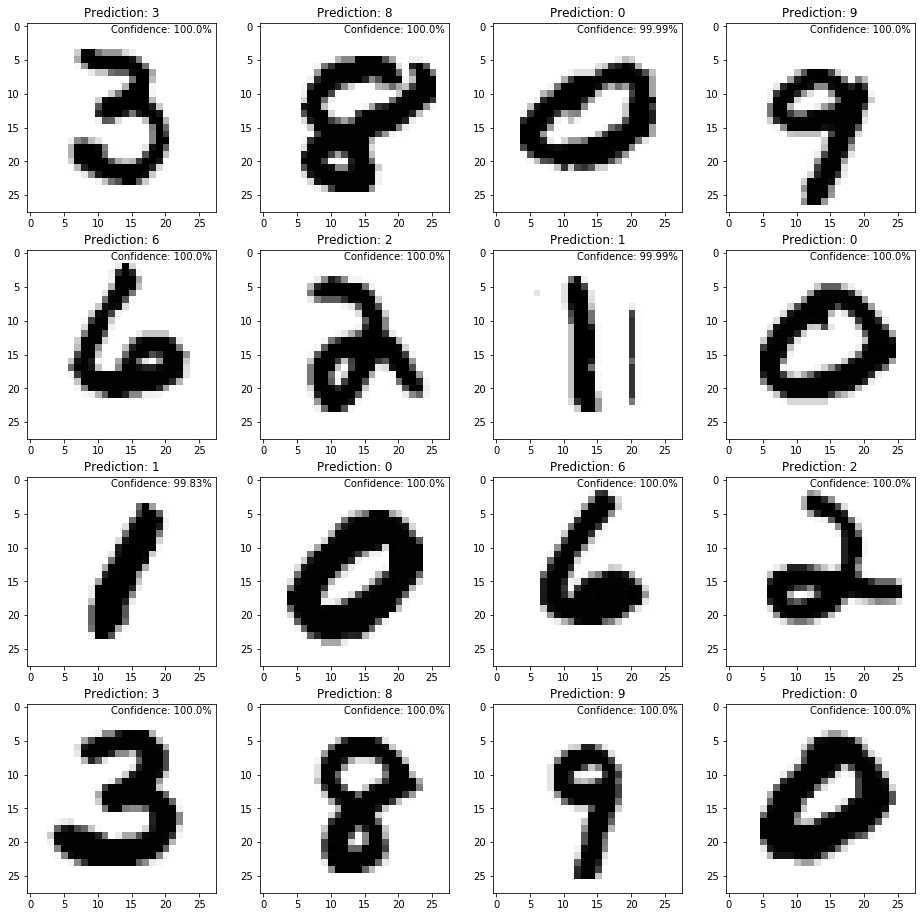

In [35]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,"Model/model")
    x_d, y_l = batch_gen(test_data, test_labels, 16)
    feed_dict = {x:x_d, y_label: y_l}
    vals = sess.run(y_pred, feed_dict=feed_dict)
    fig, ax = plt.subplots(nrows=4,ncols=4,figsize=[16,16])
    fig.patch.set_facecolor('white')
    for i,axi in enumerate(ax.flat):
        ans=np.argmax(vals[i])
        axi.set_title('Prediction: {}'.format(ans))
        axi.text(12, 1,'Confidence: {}'.format(str(round(vals[i][ans]*100,2))+"%"))
        axi.imshow(x_d[i].reshape(28,28), cmap='Greys')